In [2]:
import numpy as np
import pandas as pd
import os

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
import plotly.offline as pyo 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv("merged_divvy_tripdata.csv")

In [4]:
# Load the data
data = pd.read_csv("merged_divvy_tripdata.csv")

# Calculate the number of missing values in each column
missing_values = data.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    868772
start_station_id      868904
end_station_name      925008
end_station_id        925149
start_lat                  0
start_lng                  0
end_lat                 6102
end_lng                 6102
member_casual              0
dtype: int64


In [5]:
def preprocess_data(df):
    # Convert 'started_at' and 'ended_at' to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Convert 'start_station_id' and 'end_station_id' to string
    df['start_station_id'] = df['start_station_id'].astype(str)
    df['end_station_id'] = df['end_station_id'].astype(str)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Return the processed dataframe
    return df

# Use the function on your data
merged_df = preprocess_data(df)

print(merged_df.dtypes)

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object


In [6]:
def drop_columns(df, cols_to_drop):
    df = df.drop(cols_to_drop, axis=1)
    return df

# Drop 'start_station_id' and 'end_station_id'
cols_to_drop = ['start_station_id', 'end_station_id', 'ride_id']
merged_df = drop_columns(merged_df, cols_to_drop)

In [7]:
print(merged_df.dtypes)

rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
end_station_name              object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object


In [20]:
# Get the count of non-null values for each column
non_null_counts = merged_df.count()

# Calculate the count of null values for each column
null_counts = merged_df.isnull().sum()

# Create the figure with two traces, one for non-null values and one for null values
fig = go.Figure(data=[
    go.Bar(name='Non-null values', x=non_null_counts.index, y=non_null_counts.values),
    go.Bar(name='Missing values', x=null_counts.index, y=null_counts.values)
])

# Change the bar mode to 'stack'
fig.update_layout(barmode='stack')

# Add axis labels and title
fig.update_layout(
    xaxis_title="Column",
    yaxis_title="Count",
    title="Number of Non-null and Missing Rows per Column",
    title_font=dict(size=20),
    font=dict(size=14),
    height=600,
    template='seaborn'
)

# Show the chart
fig.show()

In [8]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


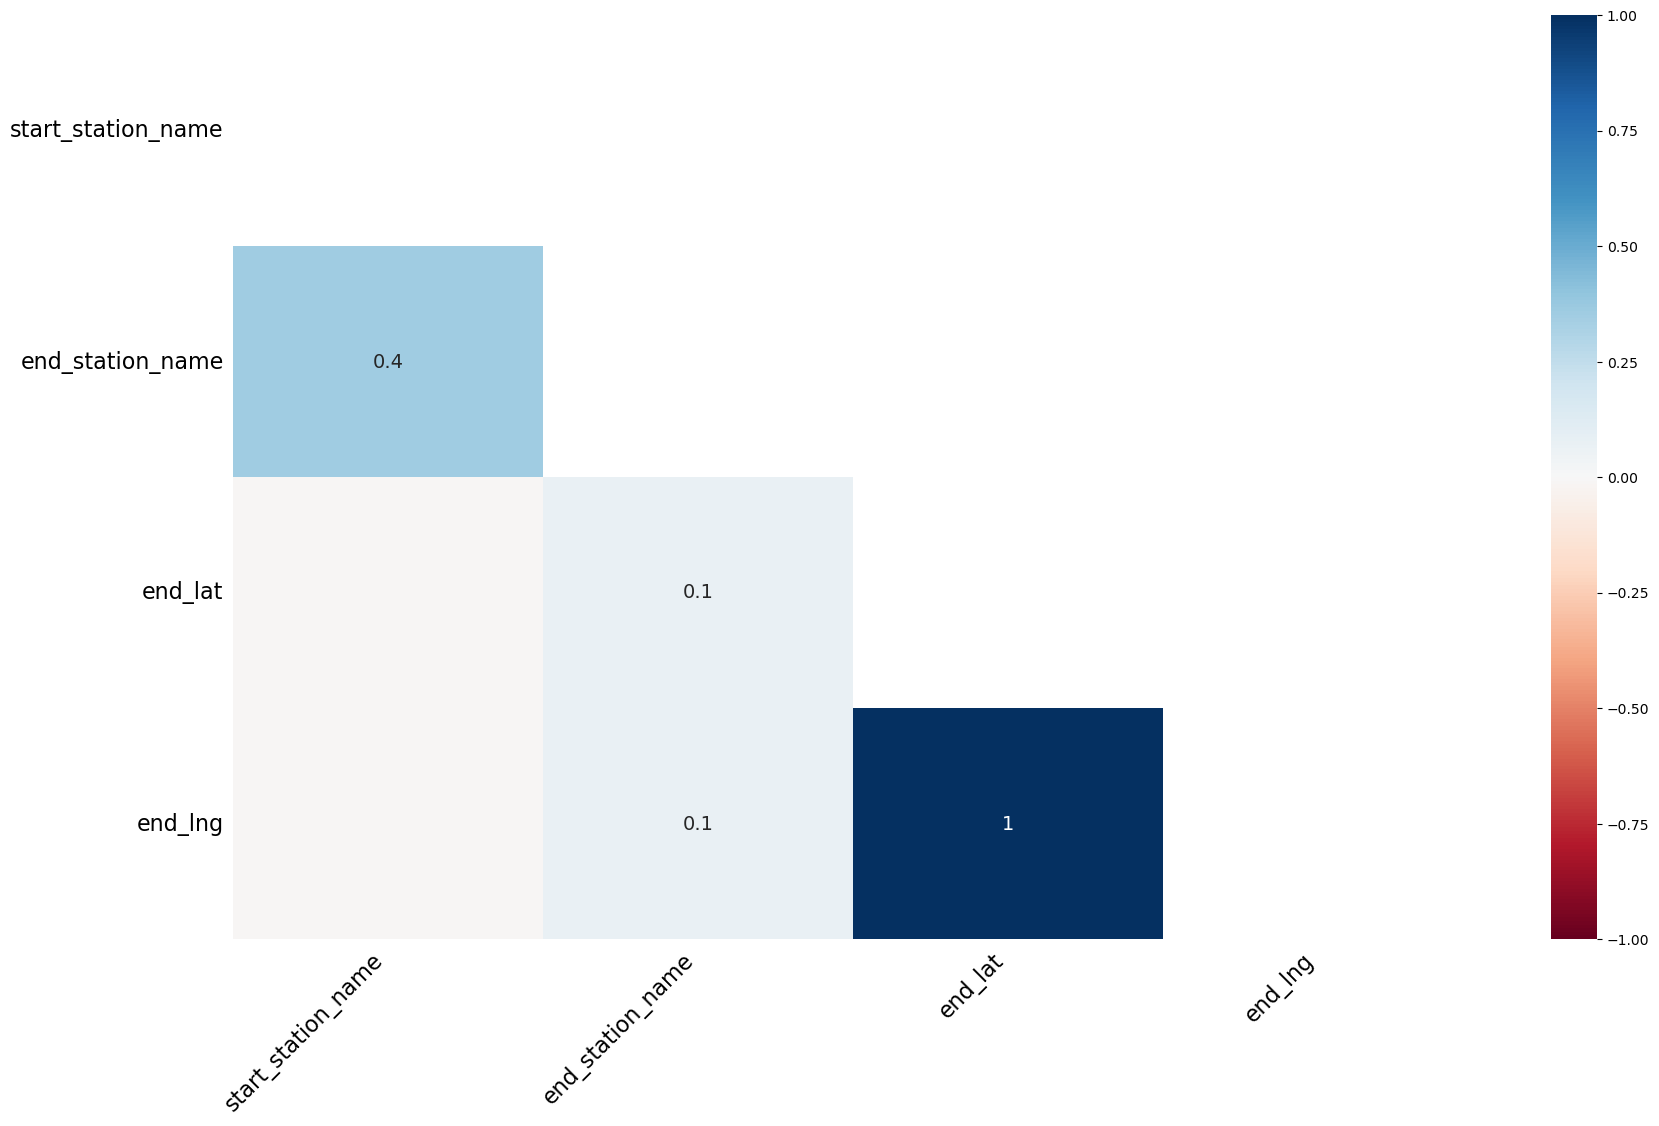

In [21]:
import missingno as msno

# Visualize the heatmap of missing values
msno.heatmap(merged_df)

# Display the plot
import matplotlib.pyplot as plt
plt.show()

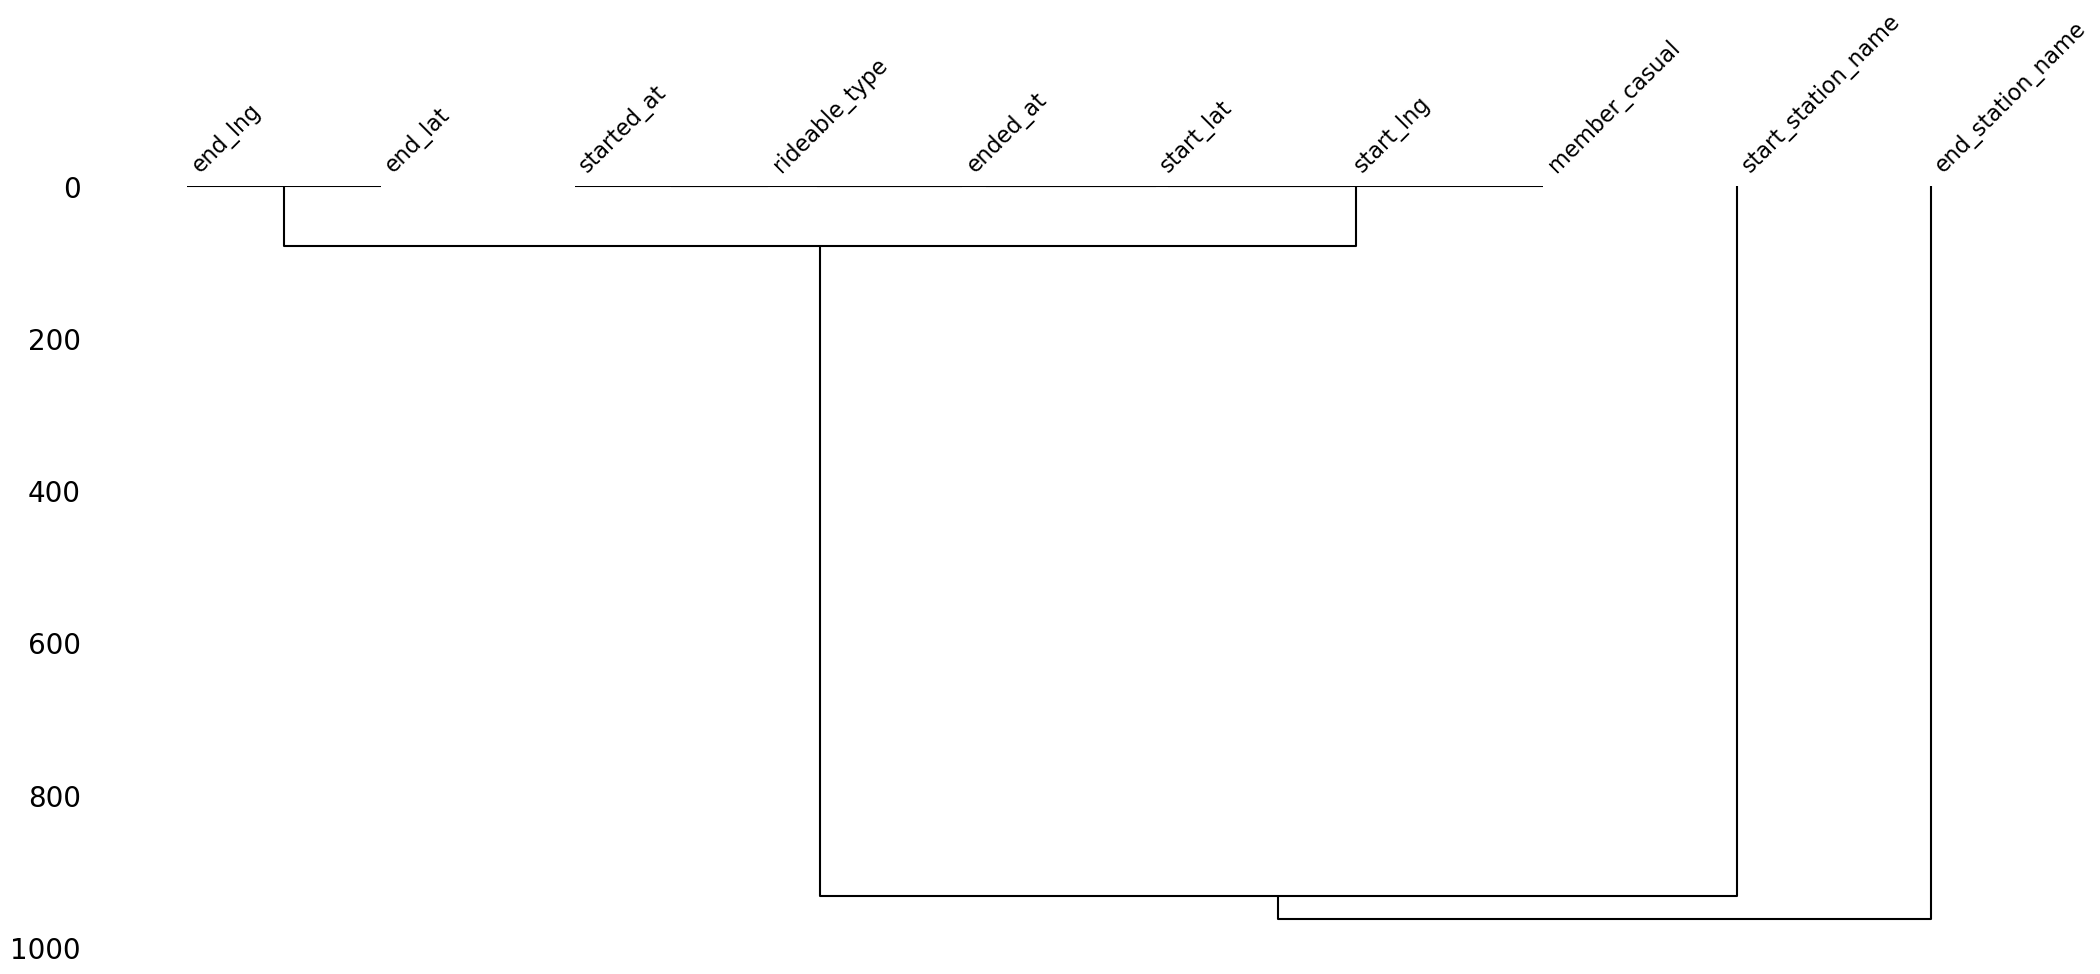

In [22]:
# Visualize the dendrogram of missing values
msno.dendrogram(merged_df)

# Display the plot
plt.show()

In [23]:
# Calculate the percentage of missing data
missing_data = merged_df.isnull().mean() * 100

# Filter out columns with no missing data
missing_data = missing_data[missing_data != 0]

# Convert the Series to a DataFrame
missing_data_df = missing_data.reset_index().rename(columns={'index': 'column', 0: 'missing_percentage'})

# Create a bar plot
fig = px.bar(missing_data_df, x='column', y='missing_percentage', 
             title='Percentage of missing data by feature',
             labels={'missing_percentage': 'Missing data (%)', 'column': 'Data Point'},
             color='missing_percentage', color_continuous_scale='agsunset_r', template='seaborn')

fig.show()

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Define custom transformer for dropping rows
class DropMissingRows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.dropna(subset=['end_lat', 'end_lng'])
        return X

# Define custom transformer for filling missing station names
class FillStationNames(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['start_station_name'].fillna('Unknown', inplace=True)
        X['end_station_name'].fillna('Unknown', inplace=True)
        return X

# Define pipeline
pipeline = Pipeline(steps=[
    ('drop_rows', DropMissingRows()),
    ('fill_names', FillStationNames())
])

# Apply pipeline to data
data = pipeline.fit_transform(merged_df)

<Axes: >

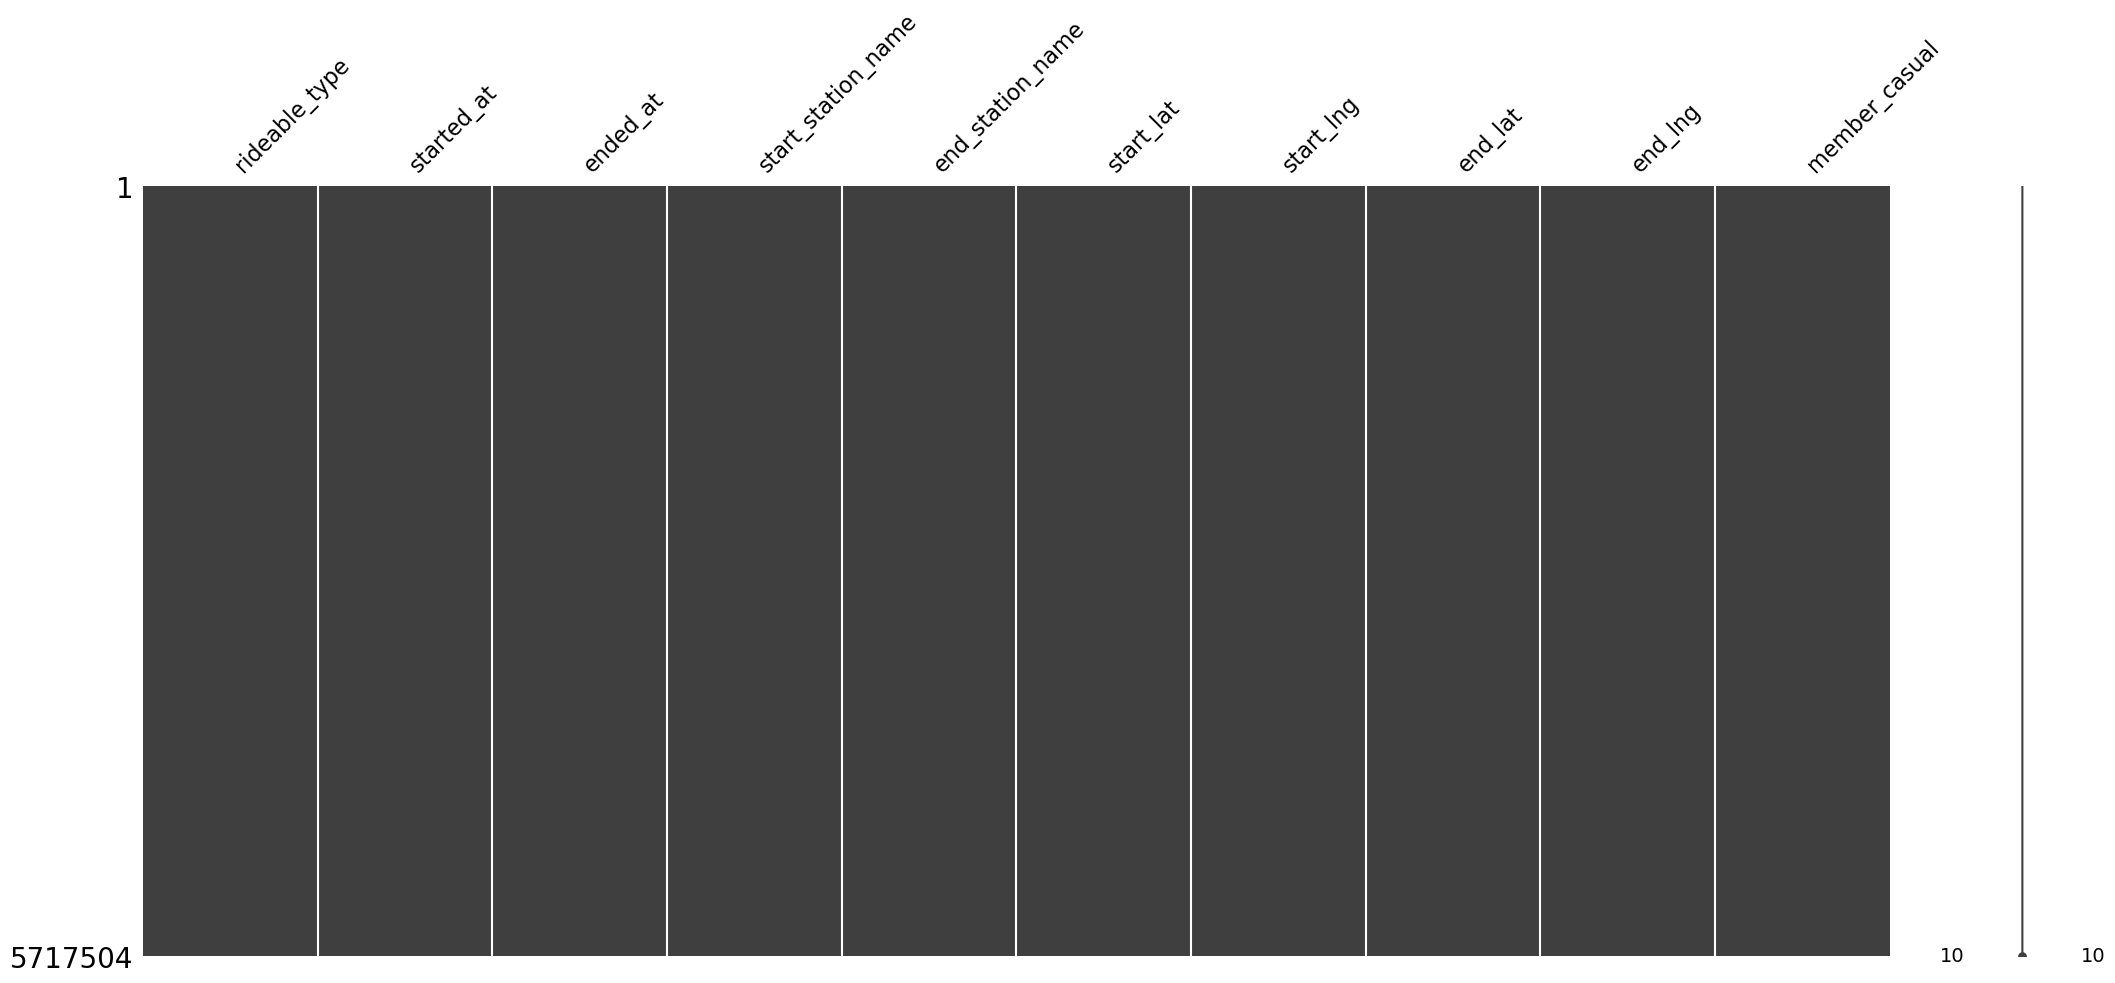

In [26]:
msno.matrix(data)

In [11]:
from math import radians, cos, sin, sqrt, atan2

def calculate_distance(row):
    # Radius of the earth in km
    R = 6371.0

    lat1 = radians(row['start_lat'])
    lon1 = radians(row['start_lng'])
    lat2 = radians(row['end_lat'])
    lon2 = radians(row['end_lng'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Convert to kilometers
    distance = R * c

    return distance

def create_features(df):
    # Create ride_length feature (in minutes)
    df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

    # Create 'day_of_week' feature
    df['day_of_week'] = df['started_at'].dt.dayofweek + 1  # Monday is 0, Sunday is 6 by default

    # Transform Monday to be 7, and then change Sunday to be 1 (Monday will be changed back to 1 as well)
    df['day_of_week'] = df['day_of_week'] % 7 + 1

    # Create hour feature
    df['hour'] = df['started_at'].dt.hour

    # Create month feature
    df['month'] = df['started_at'].dt.month

    # Create year feature
    df['year'] = df['started_at'].dt.year
    
    # Create bins for ride length
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']

    # Create a new column for ride length category
    df['ride_length_category'] = pd.cut(df['ride_length'], bins, labels=names)
    
    # Calculate the distance
    df['distance_km'] = df.apply(calculate_distance, axis=1)
    
    # Create bins for distance
    distance_bins = [0, 1, 2, 3, 4, 5, np.inf]
    distance_names = ['<1', '1-2', '2-3', '3-4', '4-5', '5+']

    # Create a new column for distance category
    df['distance_category'] = pd.cut(df['distance_km'], distance_bins, labels=distance_names)

    return df

data = create_features(data)

In [55]:
#RUN ALL CODE ABOVE FIRST

In [12]:
print(merged_df.dtypes)

rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
end_station_name              object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object


In [29]:
print(data.dtypes)

rideable_type                   object
started_at              datetime64[ns]
ended_at                datetime64[ns]
start_station_name              object
end_station_name                object
start_lat                      float64
start_lng                      float64
end_lat                        float64
end_lng                        float64
member_casual                   object
ride_length                    float64
day_of_week                      int64
hour                             int64
month                            int64
year                             int64
ride_length_category          category
distance_km                    float64
distance_category             category
dtype: object


In [30]:
print(data)

         rideable_type          started_at            ended_at  \
0        electric_bike 2022-08-07 21:34:15 2022-08-07 21:41:46   
1        electric_bike 2022-08-08 14:39:21 2022-08-08 14:53:23   
2        electric_bike 2022-08-08 15:29:50 2022-08-08 15:40:34   
3        electric_bike 2022-08-08 02:43:50 2022-08-08 02:58:53   
4        electric_bike 2022-08-07 20:24:06 2022-08-07 20:29:58   
...                ...                 ...                 ...   
5723601  electric_bike 2023-07-14 19:17:13 2023-07-14 19:26:31   
5723602  electric_bike 2023-07-14 19:16:13 2023-07-14 19:16:16   
5723603  electric_bike 2023-07-15 13:34:00 2023-07-15 13:43:13   
5723604  electric_bike 2023-07-06 20:52:09 2023-07-06 21:01:13   
5723605  electric_bike 2023-07-07 18:47:27 2023-07-07 18:51:46   

        start_station_name              end_station_name  start_lat  \
0                  Unknown                       Unknown      41.93   
1                  Unknown                       Unknown      41.

In [31]:
# Group by 'member_casual' and calculate average and median of 'ride_length'
average_ride_length = data.groupby('member_casual')['ride_length'].mean()
median_ride_length = data.groupby('member_casual')['ride_length'].median()

# Group by 'member_casual' and find the range (max - min) of 'ride_length'
range_ride_length = data.groupby('member_casual')['ride_length'].apply(lambda x: x.max() - x.min())

# Display the results
print("Average Ride Length by Member Casual:")
print(average_ride_length)

print("\nMedian Ride Length by Member Casual:")
print(median_ride_length)

print("\nRange of Ride Length by Member Casual:")
print(range_ride_length)


Average Ride Length by Member Casual:
member_casual
casual    20.292493
member    12.039315
Name: ride_length, dtype: float64

Median Ride Length by Member Casual:
member_casual
casual    11.850000
member     8.516667
Name: ride_length, dtype: float64

Range of Ride Length by Member Casual:
member_casual
casual    12196.550000
member    11853.283333
Name: ride_length, dtype: float64


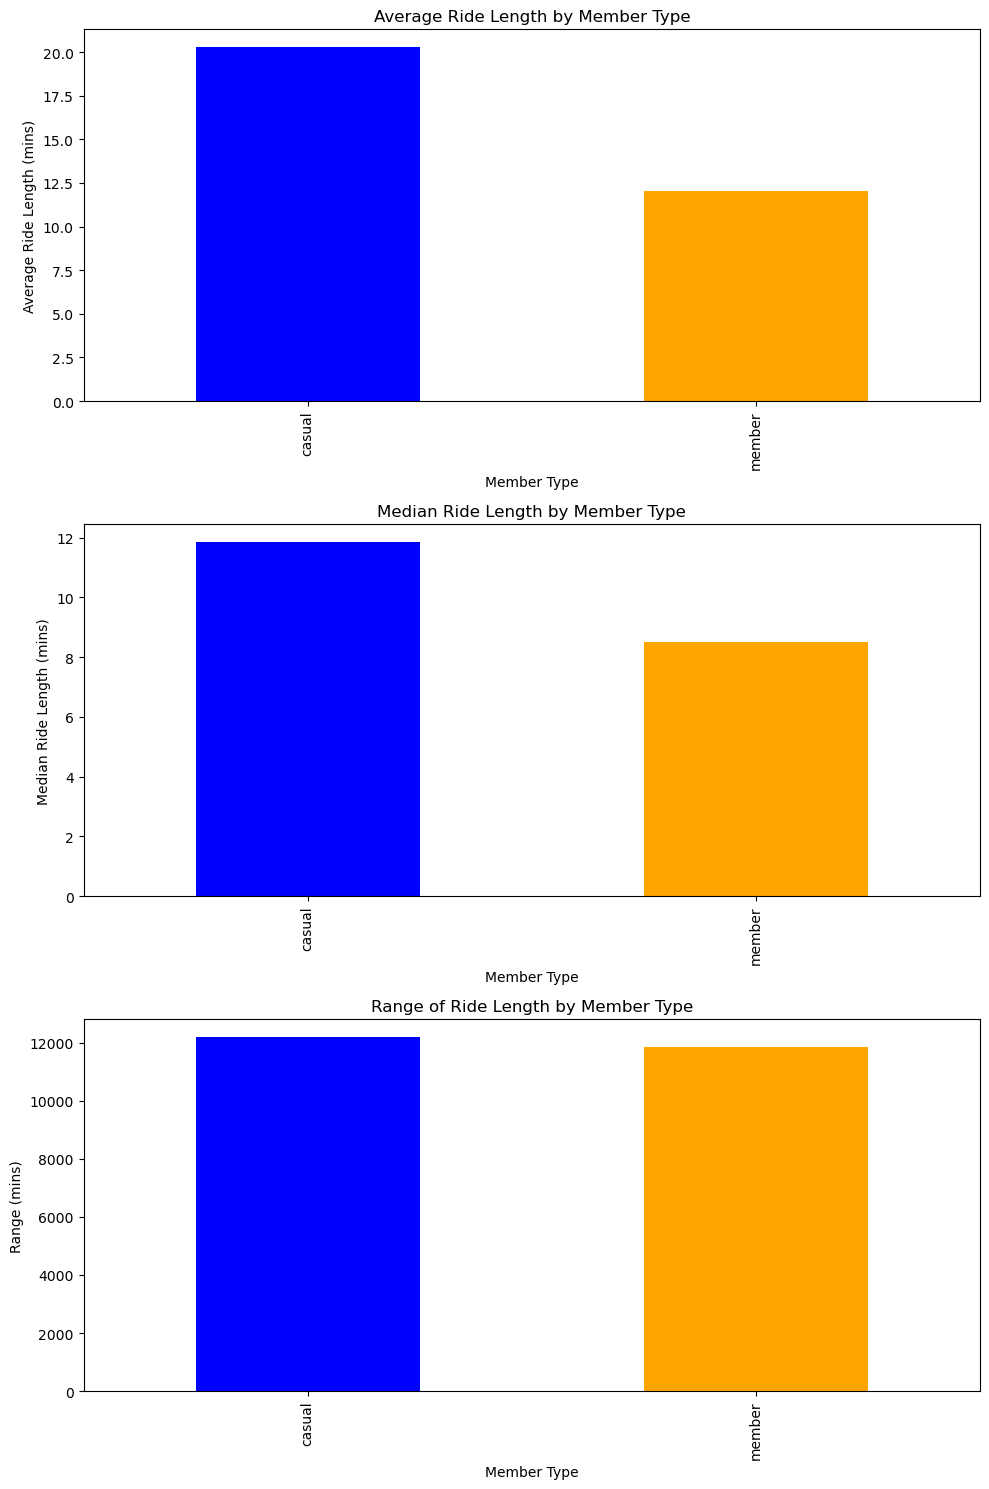

In [24]:
# Calculations
grouped_data = data.groupby('member_casual')['ride_length']

average_ride_length = grouped_data.mean()
median_ride_length = grouped_data.median()
range_ride_length = grouped_data.max() - grouped_data.min()

# Assigning colors
colors = ['blue' if member_type == 'casual' else 'orange' for member_type in average_ride_length.index]

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting average ride length
average_ride_length.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Average Ride Length by Member Type')
axes[0].set_ylabel('Average Ride Length (mins)')
axes[0].set_xlabel('Member Type')

# Plotting median ride length
median_ride_length.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Median Ride Length by Member Type')
axes[1].set_ylabel('Median Ride Length (mins)')
axes[1].set_xlabel('Member Type')

# Plotting range of ride length
range_ride_length.plot(kind='bar', ax=axes[2], color=colors)
axes[2].set_title('Range of Ride Length by Member Type')
axes[2].set_ylabel('Range (mins)')
axes[2].set_xlabel('Member Type')

plt.tight_layout()
plt.show()


In [34]:
# Calculations
grouped_distance = data.groupby('member_casual')['distance_km']

average_distance = grouped_distance.mean()
median_distance = grouped_distance.median()
range_distance = grouped_distance.max() - grouped_distance.min()

# Printing the results
print("Average distance by member type:")
print(average_distance)
print("\nMedian distance by member type:")
print(median_distance)
print("\nRange of distance by member type:")
print(range_distance)


Average distance by member type:
member_casual
casual    2.127900
member    2.103953
Name: distance_km, dtype: float64

Median distance by member type:
member_casual
casual    1.606893
member    1.503692
Name: distance_km, dtype: float64

Range of distance by member type:
member_casual
casual    9814.069405
member    9815.428757
Name: distance_km, dtype: float64


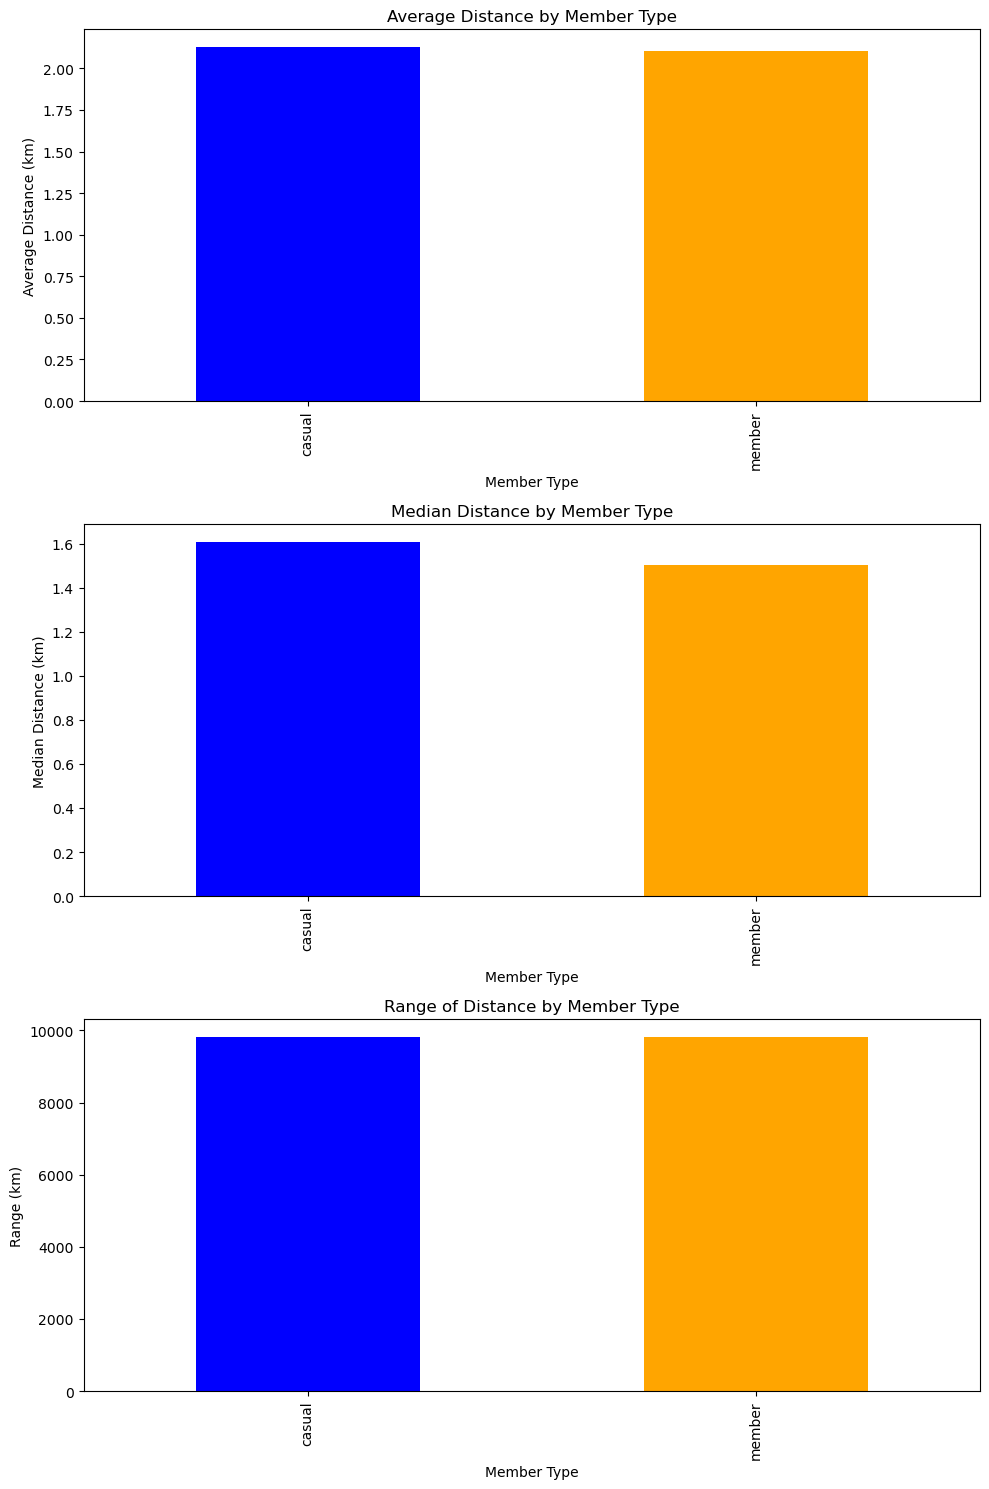

In [25]:
# Calculations
grouped_distance = data.groupby('member_casual')['distance_km']

average_distance = grouped_distance.mean()
median_distance = grouped_distance.median()
range_distance = grouped_distance.max() - grouped_distance.min()

# Assigning colors
colors = ['blue' if member_type == 'casual' else 'orange' for member_type in average_distance.index]

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting average distance
average_distance.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Average Distance by Member Type')
axes[0].set_ylabel('Average Distance (km)')
axes[0].set_xlabel('Member Type')

# Plotting median distance
median_distance.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Median Distance by Member Type')
axes[1].set_ylabel('Median Distance (km)')
axes[1].set_xlabel('Member Type')

# Plotting range of distance
range_distance.plot(kind='bar', ax=axes[2], color=colors)
axes[2].set_title('Range of Distance by Member Type')
axes[2].set_ylabel('Range (km)')
axes[2].set_xlabel('Member Type')

plt.tight_layout()
plt.show()

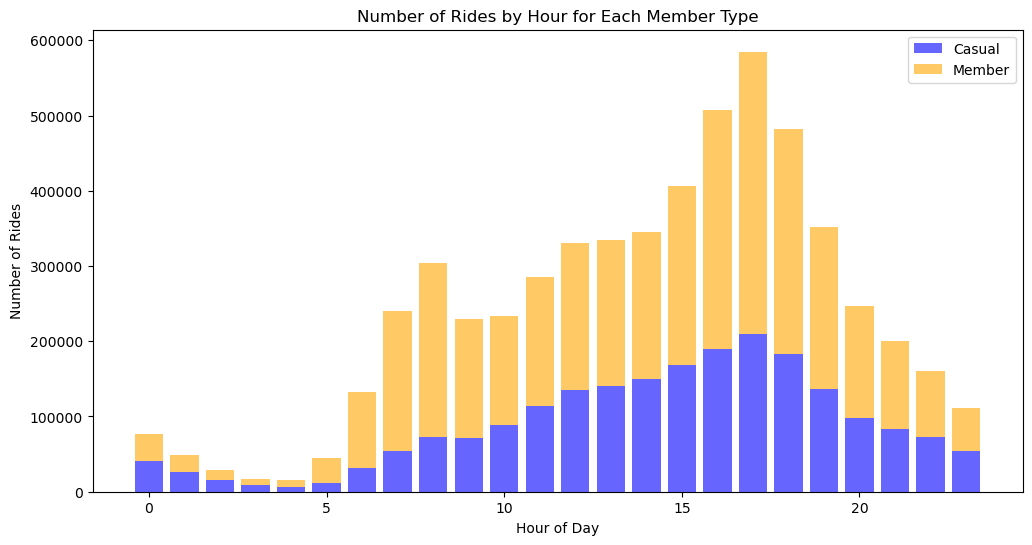

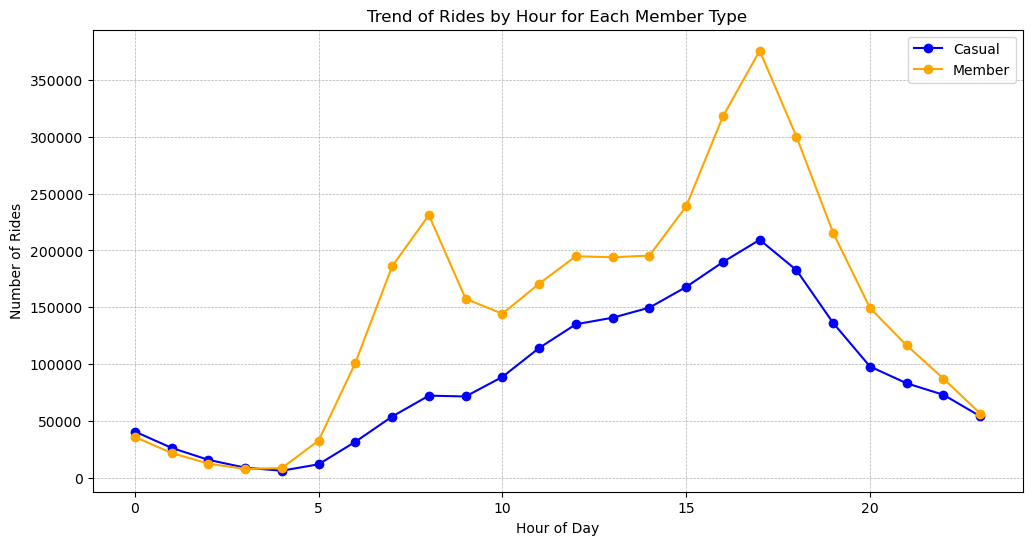

In [85]:
import matplotlib.pyplot as plt

# Grouping data
grouped_hourly = data.groupby(['hour', 'member_casual']).size().reset_index(name='count')

# Extracting data for each member type
casual_hourly = grouped_hourly[grouped_hourly['member_casual'] == 'casual']
member_hourly = grouped_hourly[grouped_hourly['member_casual'] == 'member']

# Visualization

# Histogram (Bar plot)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(casual_hourly['hour'], casual_hourly['count'], label='Casual', alpha=0.6, color='blue')
ax.bar(member_hourly['hour'], member_hourly['count'], label='Member', alpha=0.6, color='orange', bottom=casual_hourly['count']) # stacked bar plot
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Rides')
ax.set_title('Number of Rides by Hour for Each Member Type')
ax.legend()
plt.show()

# Line Chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(casual_hourly['hour'], casual_hourly['count'], label='Casual', marker='o', color='blue')
ax.plot(member_hourly['hour'], member_hourly['count'], label='Member', marker='o', color='orange')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Rides')
ax.set_title('Trend of Rides by Hour for Each Member Type')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()


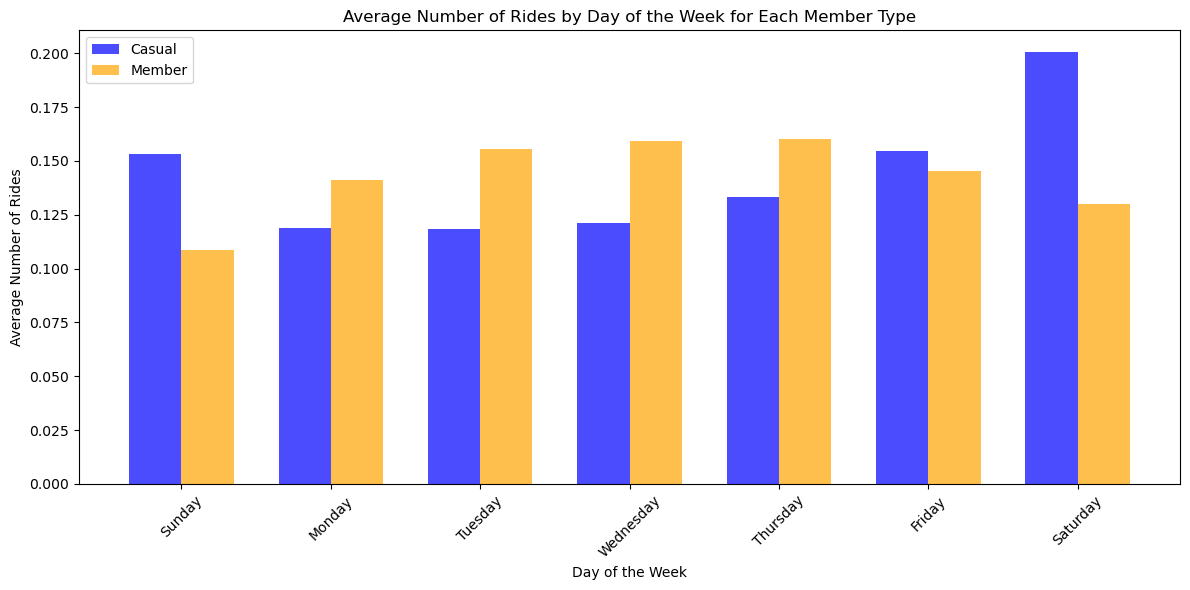

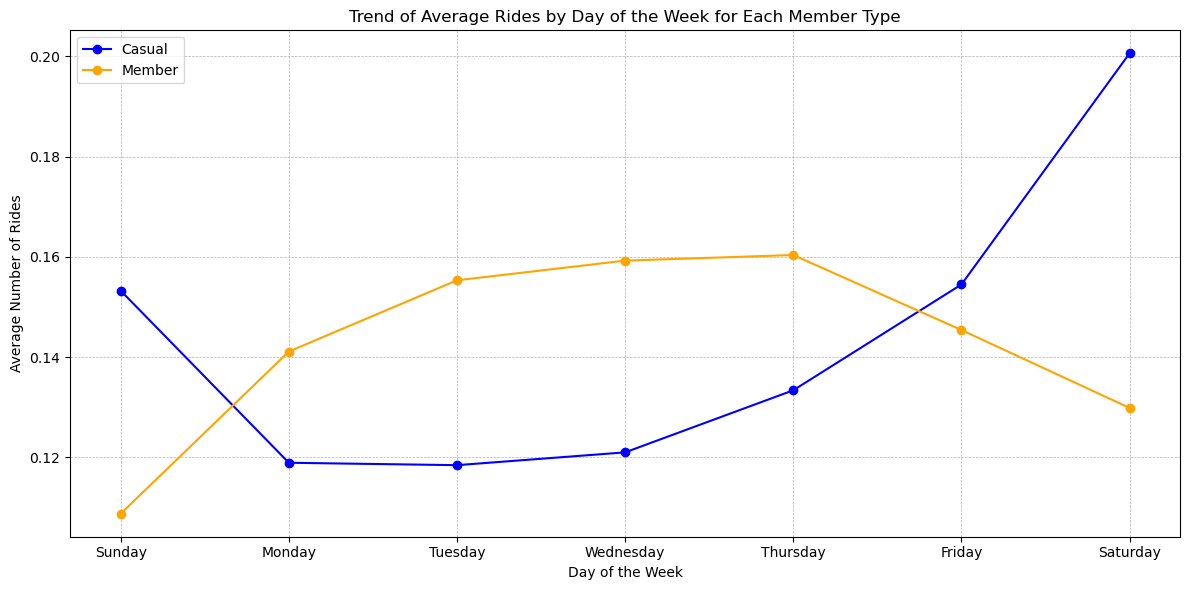

In [84]:
 # Grouping data to get the average rides on each day of the week
grouped_daily = data.groupby(['day_of_week', 'member_casual']).size().groupby(level=1).apply(
    lambda x:  x / x.sum()  # calculating the average
).reset_index(name='average_count')

# Extracting data for each member type
casual_daily = grouped_daily[grouped_daily['member_casual'] == 'casual']
member_daily = grouped_daily[grouped_daily['member_casual'] == 'member']

# Day labels for x-axis
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Visualization

# Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
ind = np.arange(len(days))
p1 = ax.bar(ind - width/2, casual_daily['average_count'], width, label='Casual', alpha=0.7, color='blue')
p2 = ax.bar(ind + width/2, member_daily['average_count'], width, label='Member', alpha=0.7, color='orange')

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Number of Rides')
ax.set_title('Average Number of Rides by Day of the Week for Each Member Type')
ax.set_xticks(ind)
ax.set_xticklabels(days, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Line Chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(days, casual_daily['average_count'], label='Casual', marker='o', color='blue')
ax.plot(days, member_daily['average_count'], label='Member', marker='o', color='orange')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Number of Rides')
ax.set_title('Trend of Average Rides by Day of the Week for Each Member Type')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()



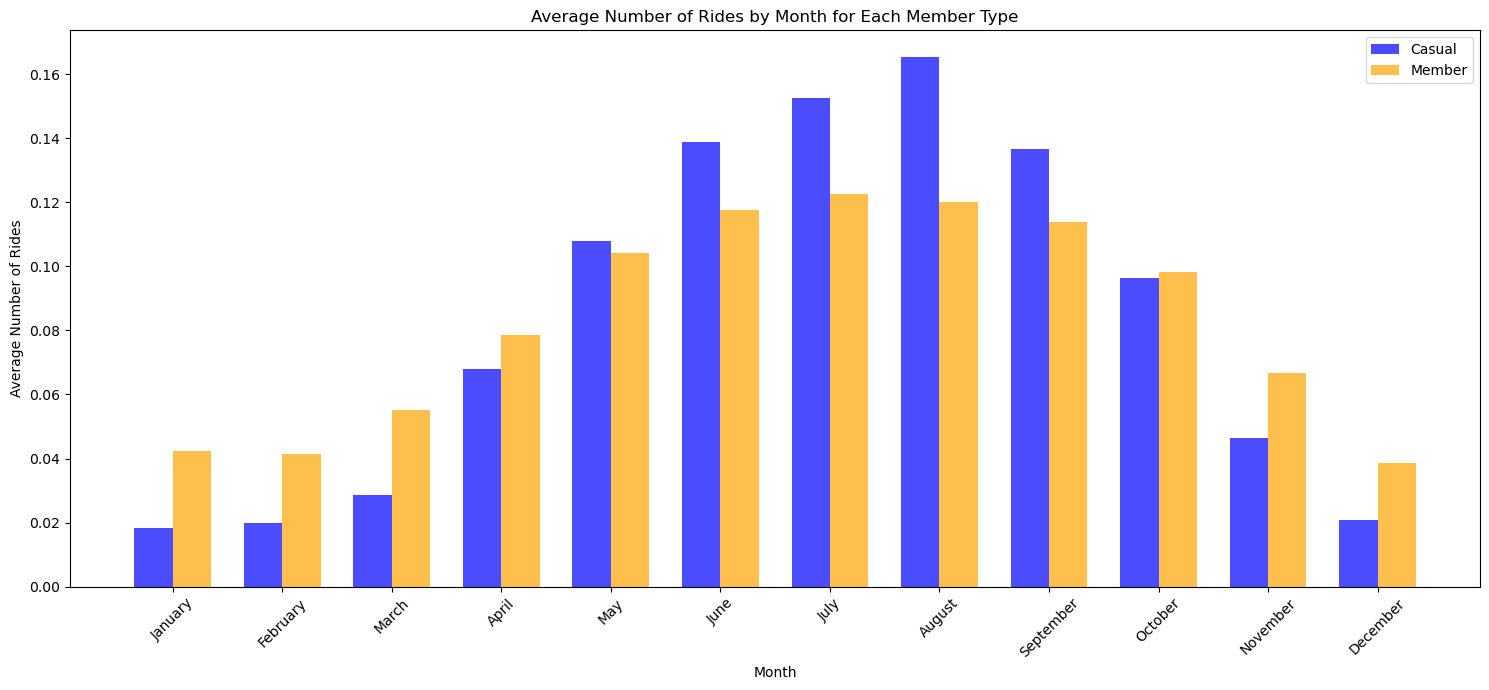

In [83]:
grouped_monthly = data.groupby(['month', 'member_casual']).size().groupby(level=1).apply(
    lambda x:  x / x.sum()  # calculating the average
).reset_index(name='average_count')

casual_monthly = grouped_monthly[grouped_monthly['member_casual'] == 'casual']
member_monthly = grouped_monthly[grouped_monthly['member_casual'] == 'member']

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

import numpy as np
import matplotlib.pyplot as plt

# Bar Chart for Monthly Data
fig, ax = plt.subplots(figsize=(15, 7))
width = 0.35
ind = np.arange(len(months))
p1 = ax.bar(ind - width/2, casual_monthly['average_count'], width, label='Casual', alpha=0.7, color='blue')
p2 = ax.bar(ind + width/2, member_monthly['average_count'], width, label='Member', alpha=0.7, color='orange')

ax.set_xlabel('Month')
ax.set_ylabel('Average Number of Rides')
ax.set_title('Average Number of Rides by Month for Each Member Type')
ax.set_xticks(ind)
ax.set_xticklabels(months, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [41]:
print(data.columns)

Index(['rideable_type', 'started_at', 'ended_at', 'start_station_name',
       'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_length', 'day_of_week', 'hour', 'month', 'year',
       'ride_length_category', 'distance_km', 'distance_category'],
      dtype='object')


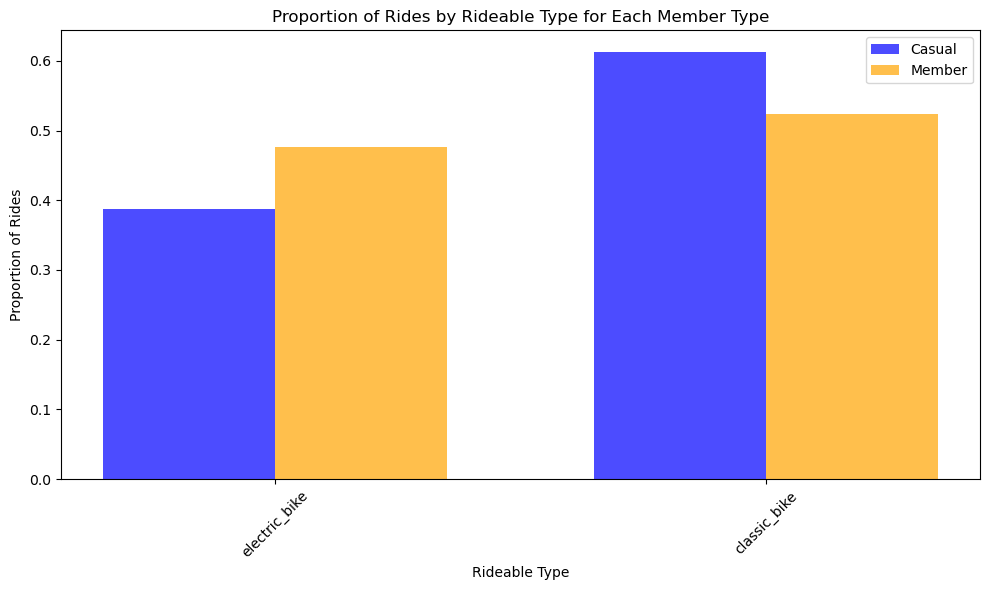

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Filter the data to keep only "electric_bike" and "classic_bike"
filtered_data = data[data['rideable_type'].isin(['electric_bike', 'classic_bike'])]

# Group by 'rideable_type' and 'member_casual' to calculate proportions
grouped_data = filtered_data.groupby(['rideable_type', 'member_casual']).size().groupby(level=1).apply(
    lambda x: x / x.sum()
).reset_index(name='proportion_count')

# Separate data for each member type
casual_data = grouped_data[grouped_data['member_casual'] == 'casual']
member_data = grouped_data[grouped_data['member_casual'] == 'member']

# Bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
rideable_labels = ['electric_bike', 'classic_bike']
ind = np.arange(len(rideable_labels))
p1 = ax.bar(ind - width/2, casual_data['proportion_count'], width, label='Casual', alpha=0.7, color='blue')
p2 = ax.bar(ind + width/2, member_data['proportion_count'], width, label='Member', alpha=0.7, color='orange')

ax.set_xlabel('Rideable Type')
ax.set_ylabel('Proportion of Rides')
ax.set_title('Proportion of Rides by Rideable Type for Each Member Type')
ax.set_xticks(ind)
ax.set_xticklabels(rideable_labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


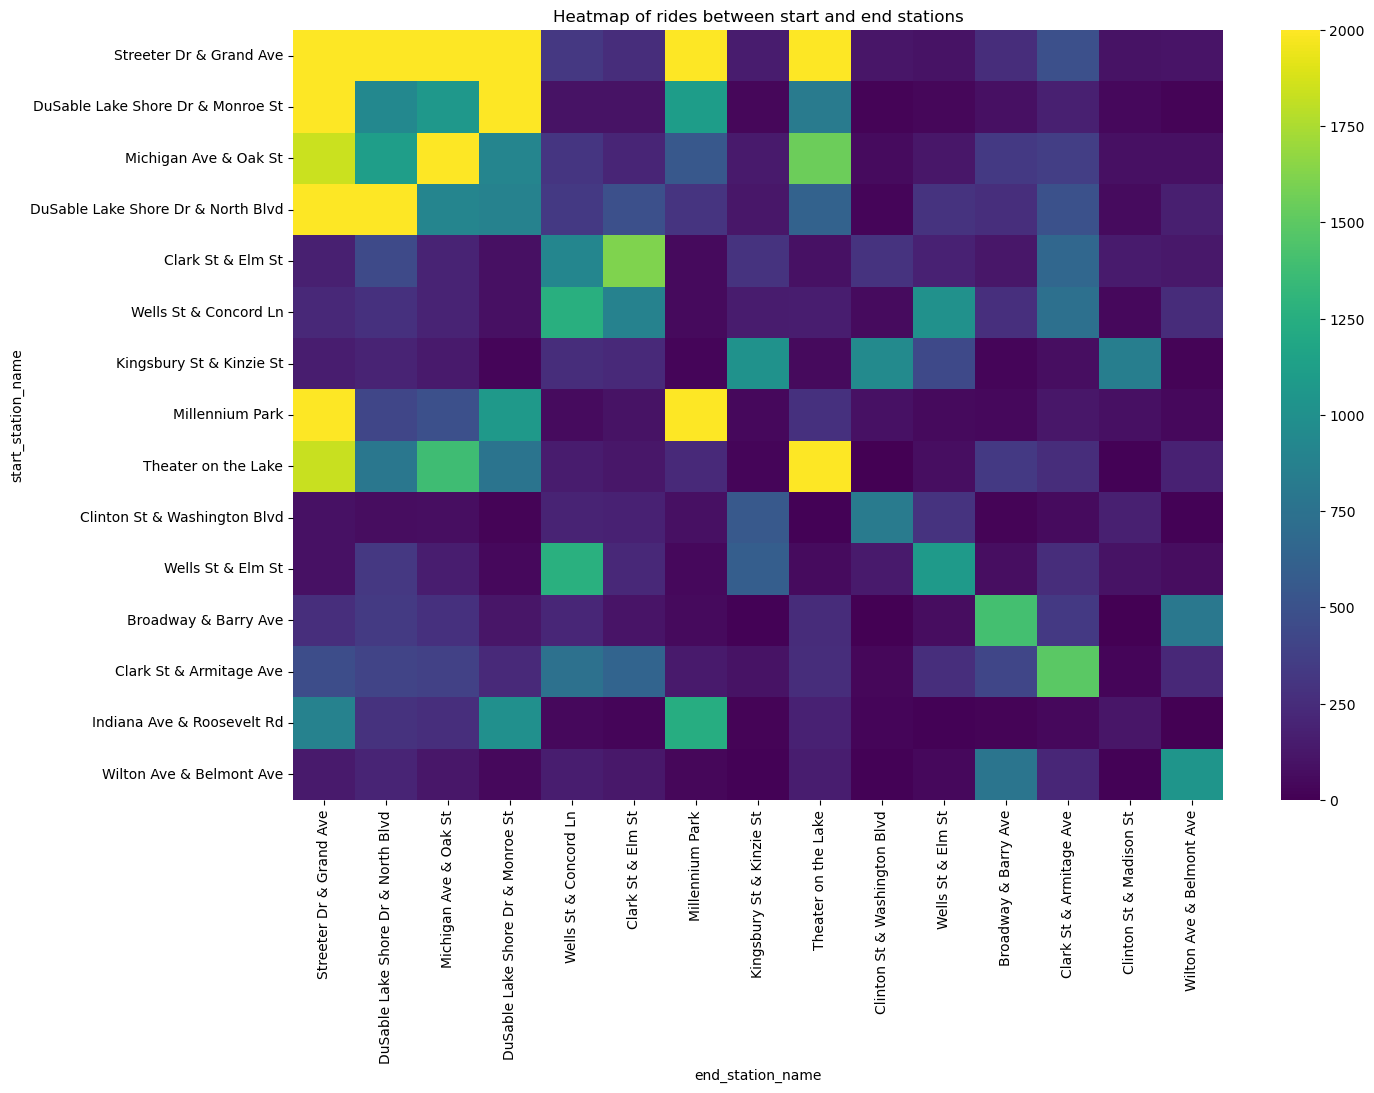

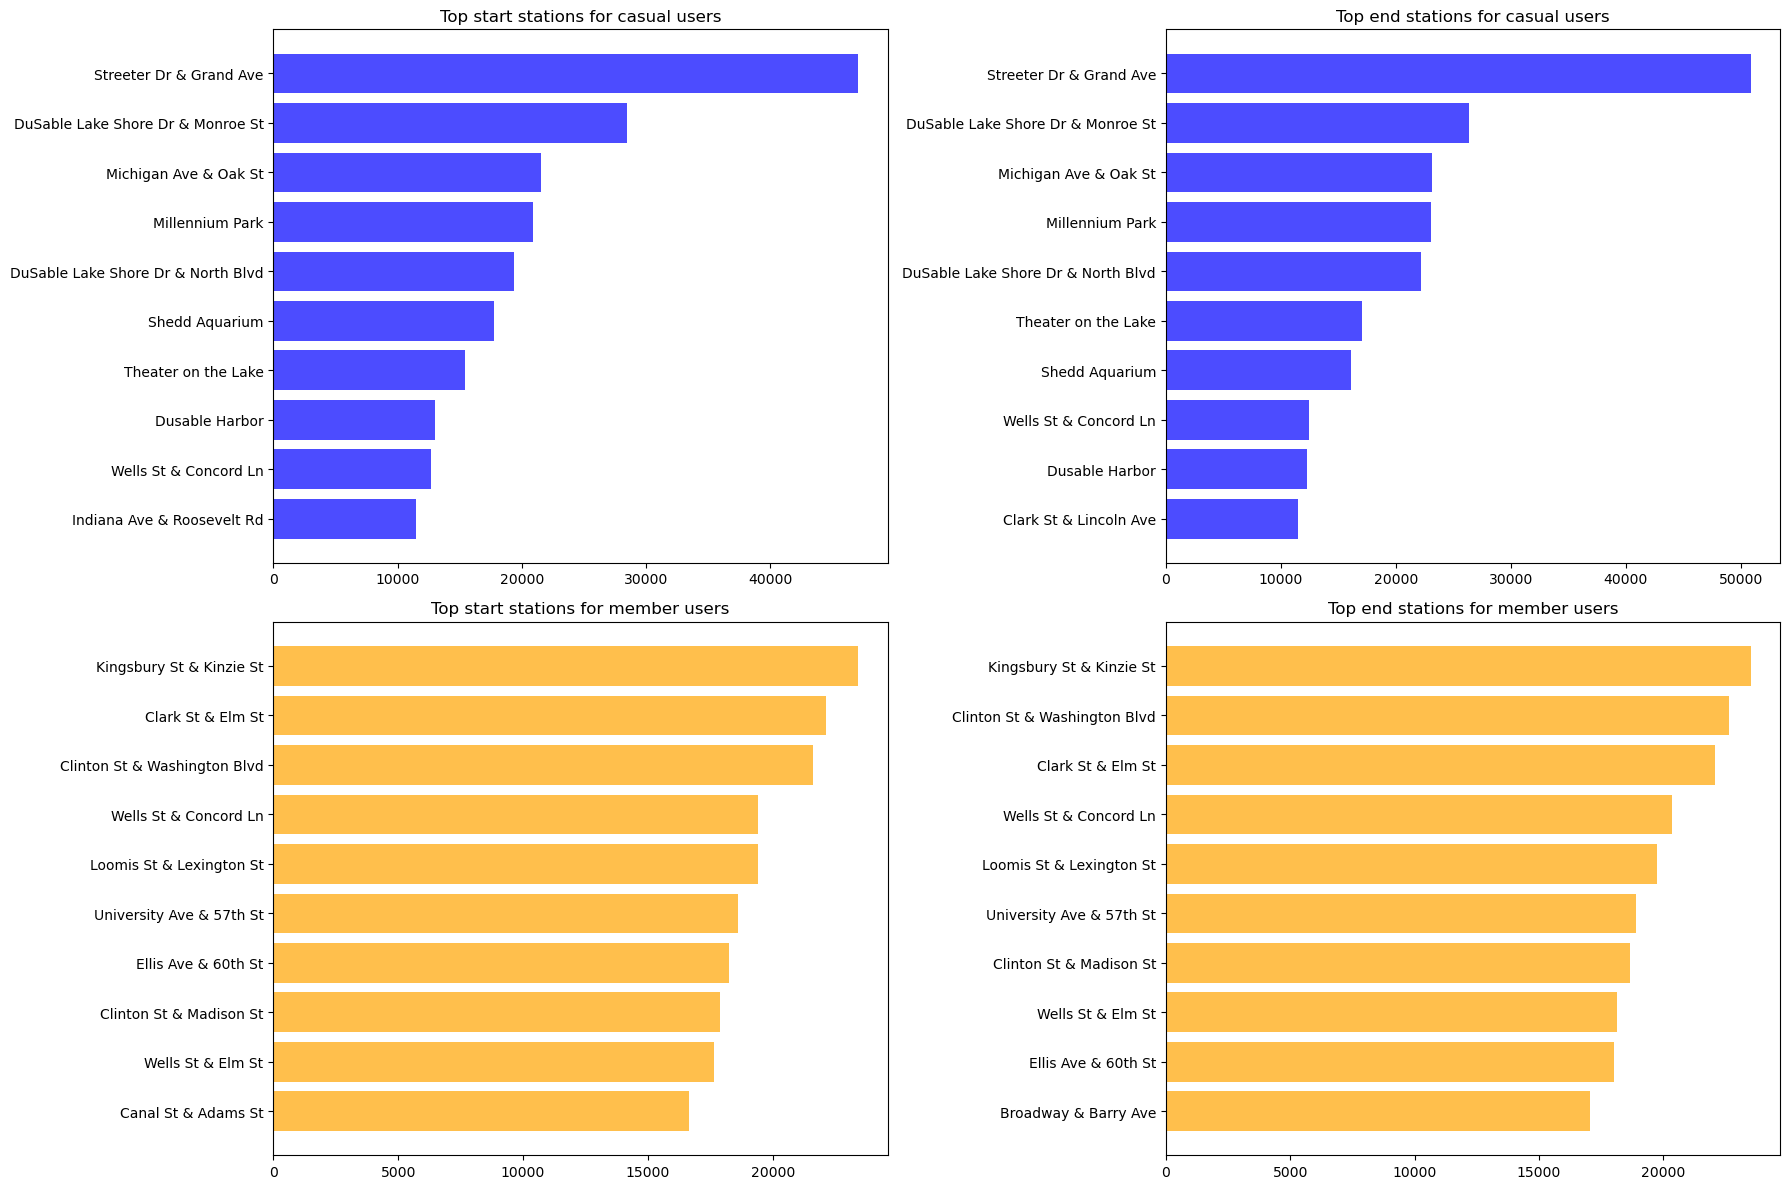

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out "Unknown" stations 
data = data[(data['start_station_name'] != 'Unknown') & (data['end_station_name'] != 'Unknown')]

# Create the pivot table
pivot_table = data.pivot_table(index='start_station_name', columns='end_station_name', 
                               values='member_casual', aggfunc='count', fill_value=0)

# Filter for the top 15 start and end stations
top_start_stations = pivot_table.sum(axis=1).nlargest(15).index
top_end_stations = pivot_table.sum(axis=0).nlargest(15).index

filtered_pivot = pivot_table.loc[top_start_stations, top_end_stations]

# Visualizing with heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(filtered_pivot, cmap='viridis', vmin=0, vmax=2000)
plt.title("Heatmap of rides between start and end stations")
plt.show()



# For the bar chart
top_n = 10  # Top 10 stations for visualization

# Start stations
start_stations = data.groupby(['member_casual', 'start_station_name']).size().reset_index(name='count')

# Filter out the "Unknown" start stations
start_stations = start_stations[start_stations['start_station_name'] != 'Unknown']

casual_start = start_stations[start_stations['member_casual'] == 'casual'].nlargest(top_n, 'count')
member_start = start_stations[start_stations['member_casual'] == 'member'].nlargest(top_n, 'count')

# End stations
end_stations = data.groupby(['member_casual', 'end_station_name']).size().reset_index(name='count')

# Filter out the "Unknown" end stations
end_stations = end_stations[end_stations['end_station_name'] != 'Unknown']

casual_end = end_stations[end_stations['member_casual'] == 'casual'].nlargest(top_n, 'count')
member_end = end_stations[end_stations['member_casual'] == 'member'].nlargest(top_n, 'count')

# Rest of your plotting code remains unchanged.

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Start stations bar charts
ax[0, 0].barh(casual_start['start_station_name'], casual_start['count'], color='blue', alpha=0.7)
ax[0, 0].set_title("Top start stations for casual users")
ax[0, 0].invert_yaxis()

ax[1, 0].barh(member_start['start_station_name'], member_start['count'], color='orange', alpha=0.7)
ax[1, 0].set_title("Top start stations for member users")
ax[1, 0].invert_yaxis()

# End stations bar charts
ax[0, 1].barh(casual_end['end_station_name'], casual_end['count'], color='blue', alpha=0.7)
ax[0, 1].set_title("Top end stations for casual users")
ax[0, 1].invert_yaxis()

ax[1, 1].barh(member_end['end_station_name'], member_end['count'], color='orange', alpha=0.7)
ax[1, 1].set_title("Top end stations for member users")
ax[1, 1].invert_yaxis()



plt.tight_layout()
plt.show()


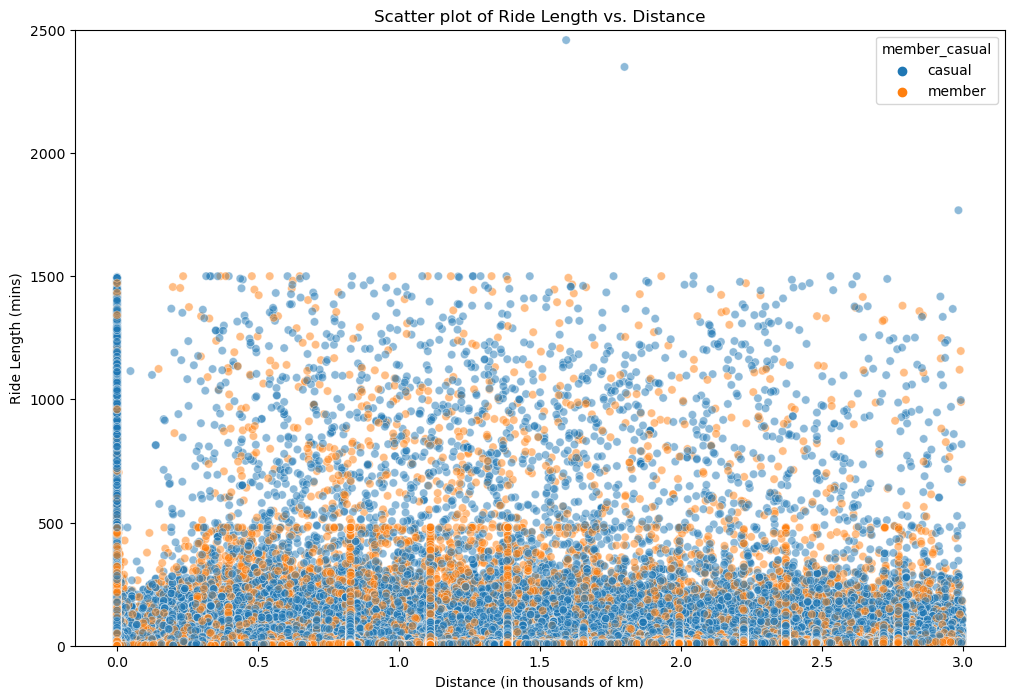

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data
filtered_data = data[data['distance_km'] <= 3]  # Since you mentioned 2000km which is equal to 2 in distance_km (assuming that distance_km is in thousands of km)

plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(data=filtered_data, x='distance_km', y='ride_length', hue='member_casual', alpha=0.5)

# Title and labels
plt.title('Scatter plot of Ride Length vs. Distance')
plt.xlabel('Distance (in thousands of km)')
plt.ylabel('Ride Length (mins)')
plt.ylim(0, 2500)  # Y-axis limit

plt.show()


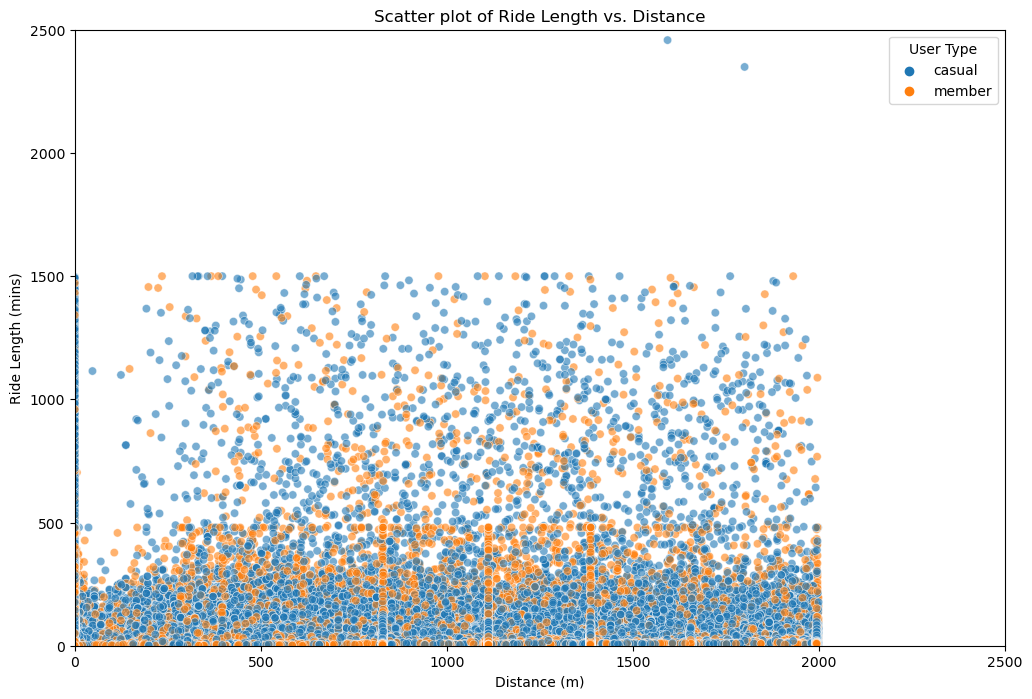

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data based on given constraints
filtered_data = data[(data['distance_km'] <= 2) & (data['distance_km'] >= 0)]

# Convert "distance_km" to "distance_m"
filtered_data['distance_m'] = filtered_data['distance_km'] * 1000

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_data, x='distance_m', y='ride_length', hue='member_casual', alpha=0.6)

# Title and labels
plt.title('Scatter plot of Ride Length vs. Distance')
plt.xlabel('Distance (m)')
plt.xlim(0, 2500)  # setting x axis limit to 2500 meters
plt.ylim(0, 2500)  # Y-axis limit
plt.ylabel('Ride Length (mins)')
plt.legend(title='User Type')

plt.show()



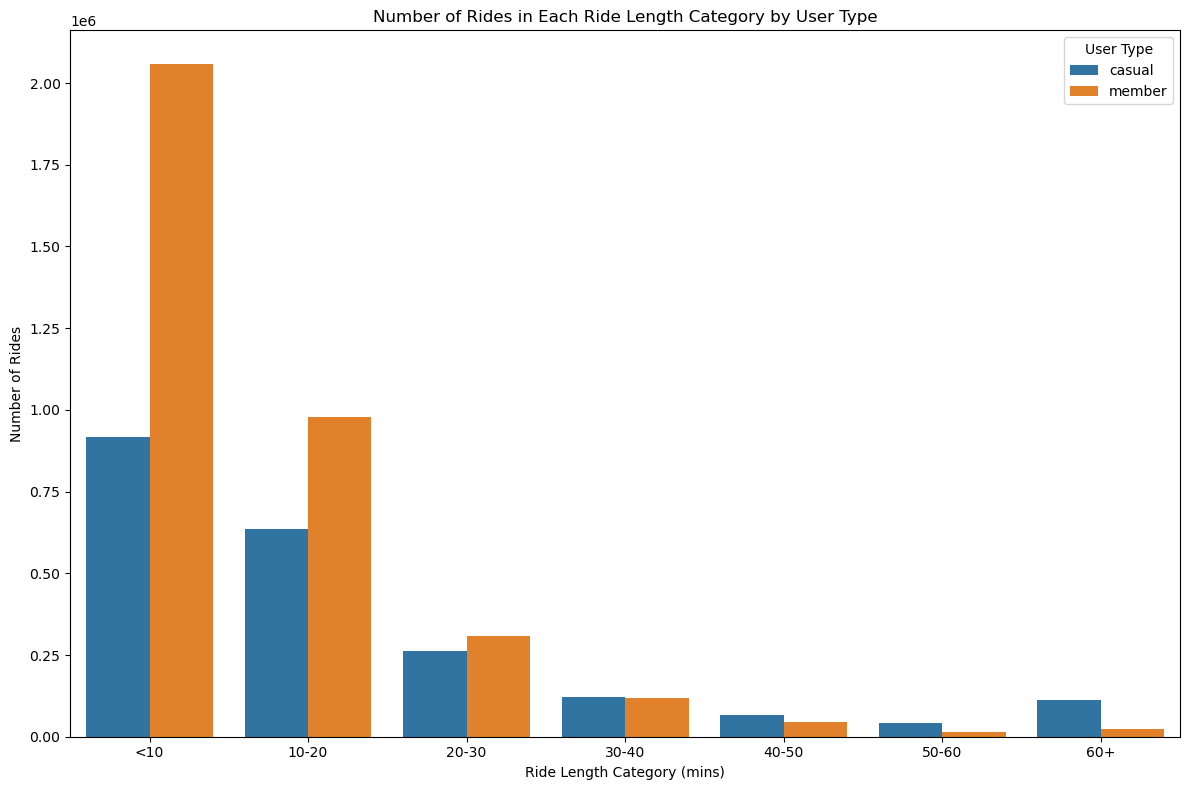

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot will directly count the occurrences in each category
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='ride_length_category', hue='member_casual')

plt.title('Number of Rides in Each Ride Length Category by User Type')
plt.xlabel('Ride Length Category (mins)')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.tight_layout()
plt.show()

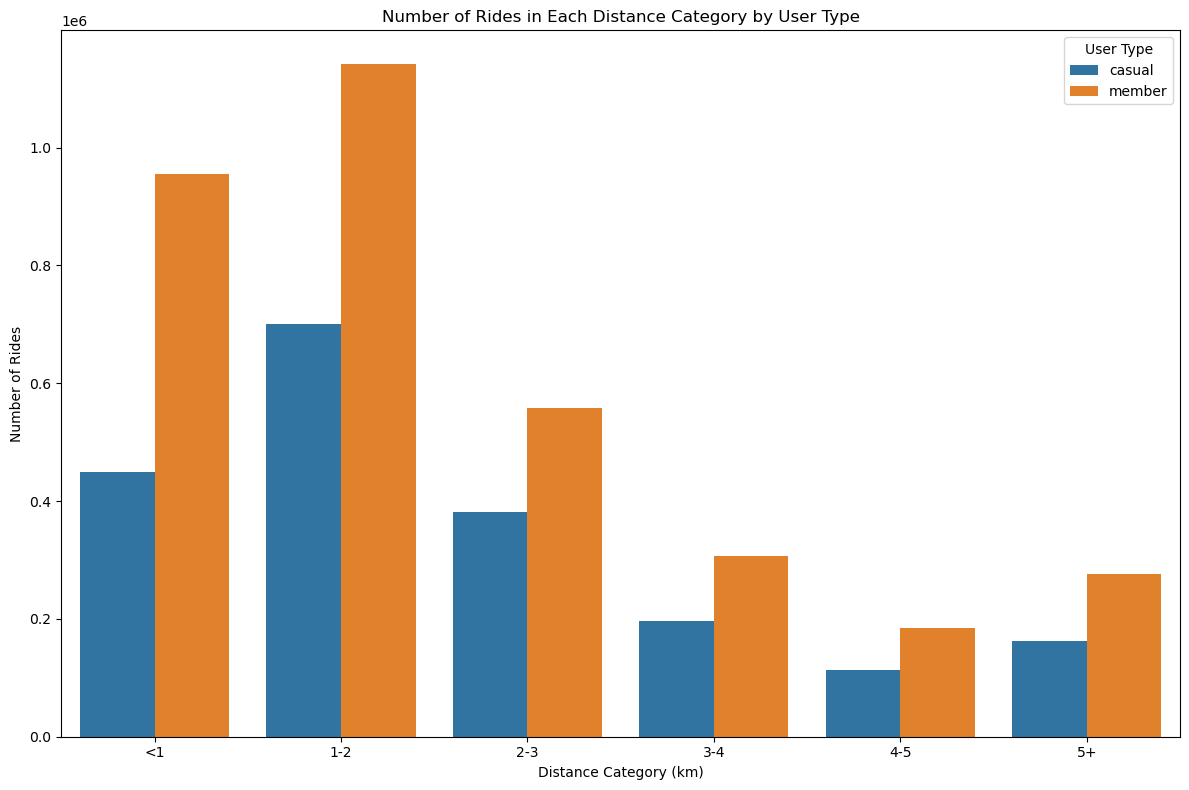

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot will directly count the occurrences in each category
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='distance_category', hue='member_casual')

plt.title('Number of Rides in Each Distance Category by User Type')
plt.xlabel('Distance Category (km)')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.tight_layout()
plt.show()


In [65]:
pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [77]:
#Marionette
data_clean = data.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

m = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

subset = data_clean.sample(500)

for idx, row in subset.iterrows():
    start_location = [row['start_lat'], row['start_lng']]
    end_location = [row['end_lat'], row['end_lng']]
    
    folium.CircleMarker(location=start_location, 
                        radius=5,
                        color="blue", 
                        fill=True).add_to(m)
    
    folium.CircleMarker(location=end_location, 
                        radius=5, 
                        color="red", 
                        fill=True).add_to(m)

    folium.PolyLine(locations=[start_location, end_location], 
                    color="green", 
                    weight=2.5, 
                    opacity=0.7).add_to(m)

m

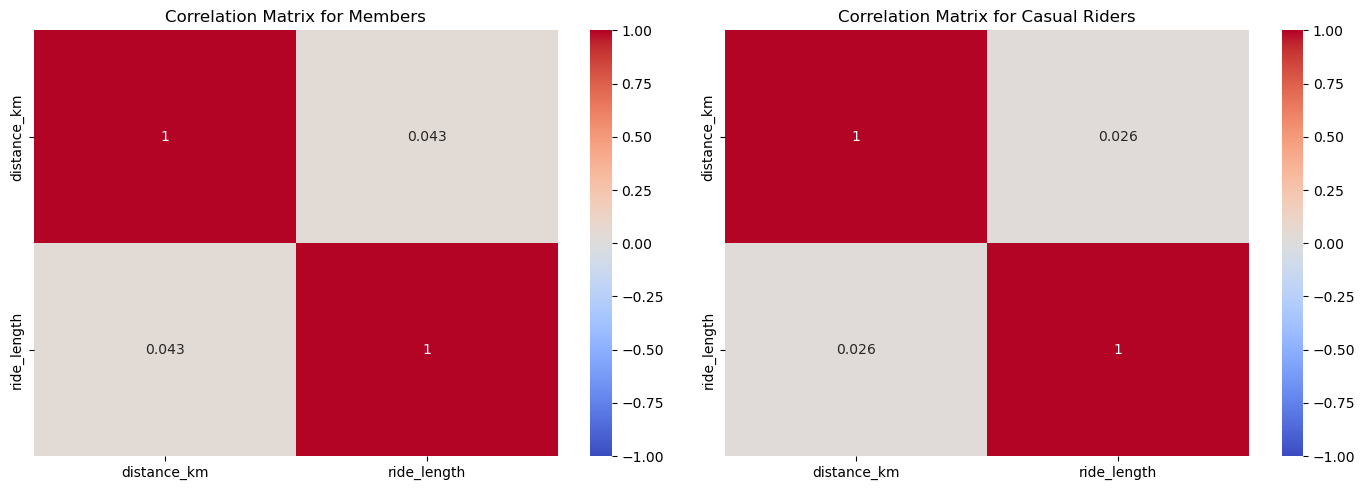

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for members and casual riders
member_data = data[data['member_casual'] == 'member'][['distance_km', 'ride_length']]
casual_data = data[data['member_casual'] == 'casual'][['distance_km', 'ride_length']]

# Calculate correlation matrices
member_corr = member_data.corr()
casual_corr = casual_data.corr()

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot member correlation matrix
sns.heatmap(member_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title('Correlation Matrix for Members')

# Plot casual correlation matrix
sns.heatmap(casual_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title('Correlation Matrix for Casual Riders')

plt.tight_layout()
plt.show()


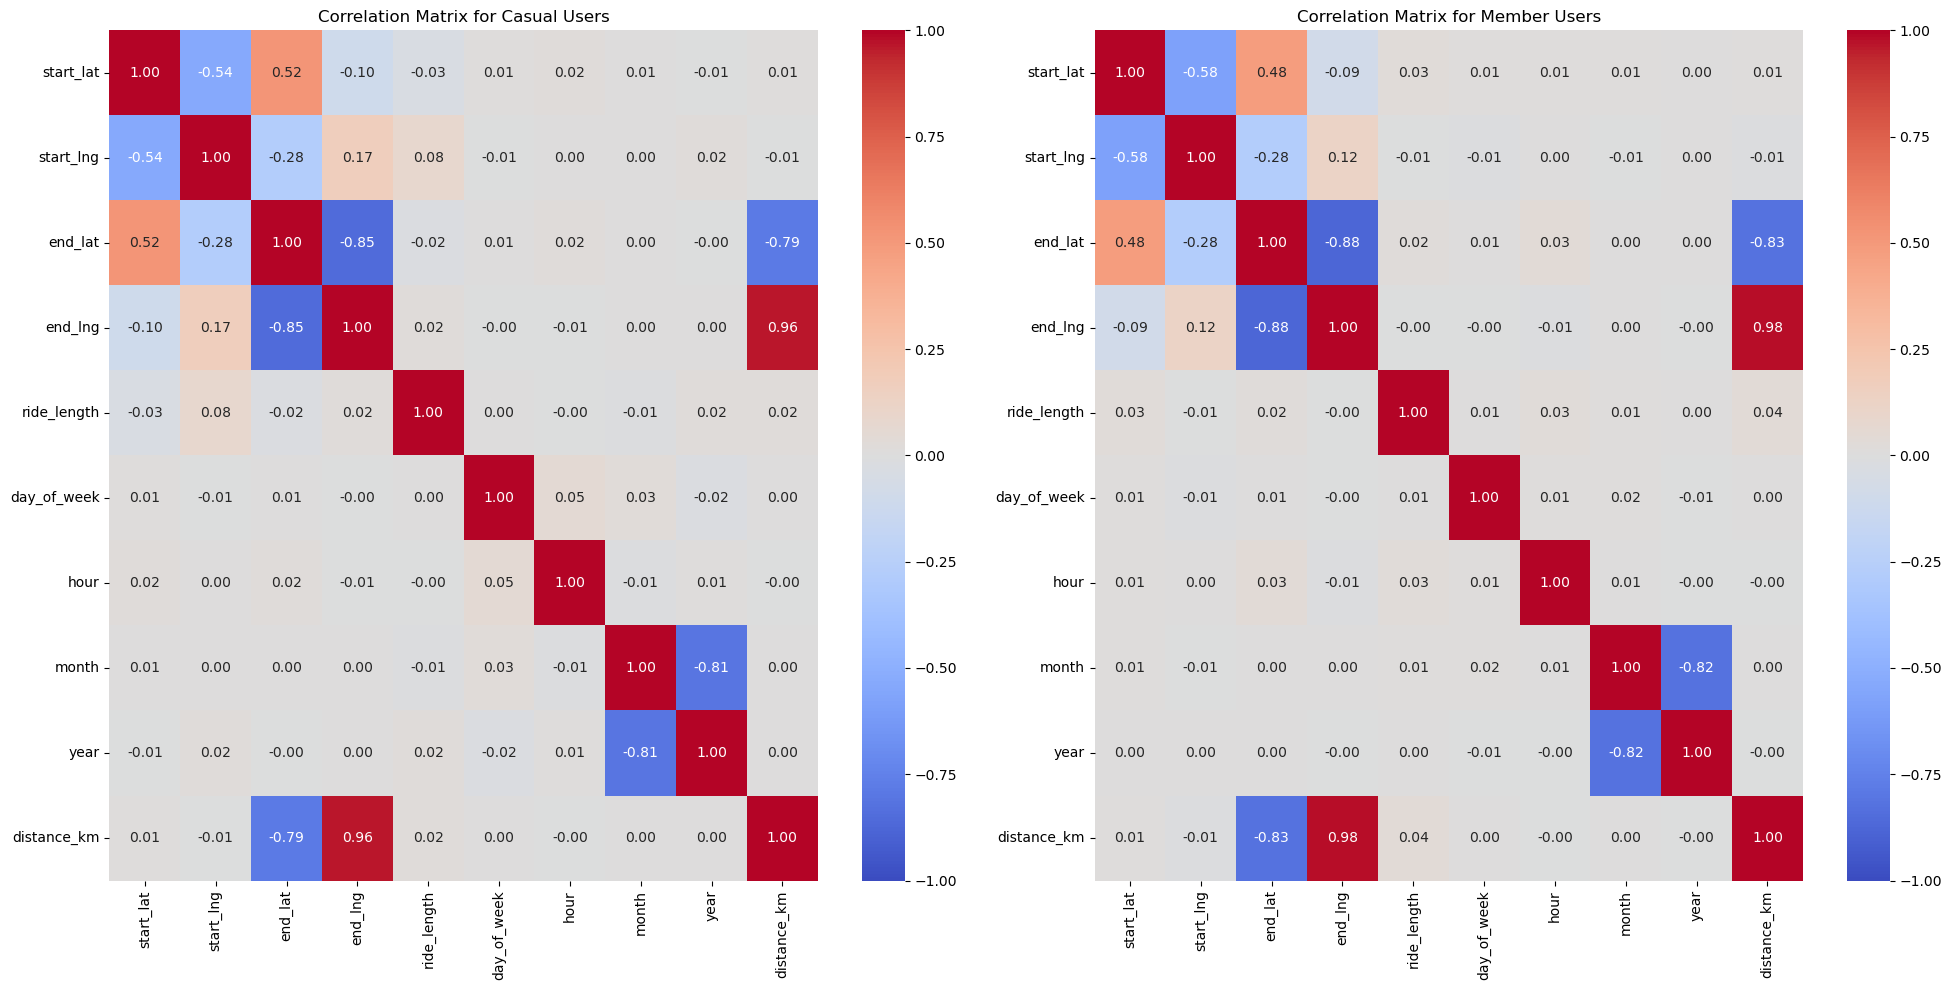

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split data based on 'member_casual'
casual_data = data[data['member_casual'] == 'casual']
member_data = data[data['member_casual'] == 'member']

# Compute the correlation matrices
casual_corr = casual_data.corr()
member_corr = member_data.corr()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(casual_corr, cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, annot=True, fmt=".2f")
axes[0].set_title('Correlation Matrix for Casual Users')

sns.heatmap(member_corr, cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, annot=True, fmt=".2f")
axes[1].set_title('Correlation Matrix for Member Users')

plt.tight_layout()
plt.show()
